# Brent Oil Price Forecast with LSTM Model

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils.vis_utils import plot_model
import matplotlib as mpl
import matplotlib.pyplot as plt
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.9.0
Num GPUs Available:  0


## Reading dataset

In [2]:
df = pd.read_excel(io='https://www.eia.gov/dnav/pet/hist_xls/RBRTEd.xls', sheet_name='Data 1', skiprows = 2)
df = df.rename({'Europe Brent Spot Price FOB (Dollars per Barrel)': 'Price'}, axis='columns')
df.shape

(9019, 2)

Note the date gaps.

## Drop negative prices if any

In [3]:
indexNames = df[df['Price'] < 0].index
df.drop(indexNames , inplace=True)
df.shape

(9019, 2)

## Filling date gaps

For market closed dates, use the previous date's price.

In [4]:
#make dates the index
df.set_index(pd.DatetimeIndex(df.Date), inplace=True)
#fill date gaps
df = df.resample('D').pad()
#fix the Date column
df.Date = df.index.values
df.shape

(12977, 2)

In [5]:
df.tail()

,Date,Price
Date,,
2022-11-24,2022-11-24,85.59
2022-11-25,2022-11-25,83.40
2022-11-26,2022-11-26,83.40
2022-11-27,2022-11-27,83.40
2022-11-28,2022-11-28,83.50


## Preparing the time series dataset

In [6]:
time_step = [i for i in range(df.shape[0])]
series = np.array(df[['Price']])
time = np.array(time_step)

## Functions

In [7]:
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Visualizing the time series dataset

Text(0.5, 1.0, 'Brent Oil Price')

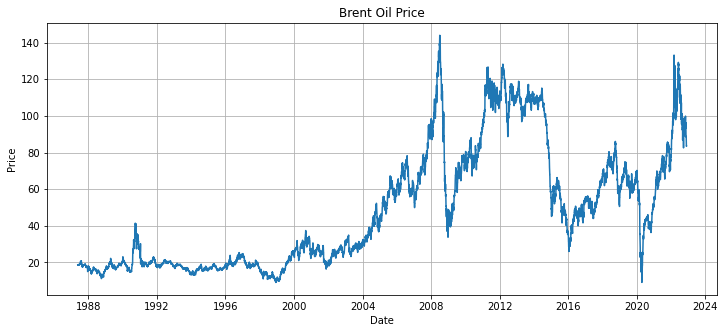

In [10]:
plt.figure(figsize=(12, 5))
plot_series(df['Date'], df['Price'])
plt.title('Brent Oil Price')

## Spliting the dataset for training and validation

In [11]:
split_time = 11500
time_train = time[:split_time]
x_train = series[:split_time]
x_label_train = df[['Date']][:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]
x_label_valid = df[['Date']][split_time:]

## Hyperparameters

In [12]:
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000
epochs = 500

## Tuning the learning rate

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                      strides = 1, padding = "causal",
                      activation = "relu",
                      input_shape = [None, 1]),
  tf.keras.layers.LSTM(64, return_sequences = True),
  tf.keras.layers.LSTM(64, return_sequences = True),
  tf.keras.layers.Dense(30, activation = "relu"),
  tf.keras.layers.Dense(10, activation = "relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-8, momentum = 0.9)
model.compile(optimizer = optimizer, loss = tf.keras.losses.Huber(), metrics = ["mae"])
history_tune = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1, 1), dtype=tf.float64, name=None))>
(11500, 1)
Epoch 1/100
45/45 [==============================] - 12s 212ms/step - loss: 48.5430 - mae: 49.0429 - lr: 1.0000e-08
Epoch 2/100
45/45 [==============================] - 10s 219ms/step - loss: 37.4642 - mae: 37.9603 - lr: 1.1220e-08
Epoch 3/100
45/45 [==============================] - 10s 217ms/step - loss: 32.0064 - mae: 32.4913 - lr: 1.2589e-08
Epoch 4/100
45/45 [==============================] - 10s 212ms/step - loss: 29.5851 - mae: 30.0707 - lr: 1.4125e-08
Epoch 5/100
45/45 [==============================] - 10s 214ms/step - loss: 27.5611 - mae: 28.0454 - lr: 1.5849e-08
Epoch 6/100
45/45 [==============================] - 10s 212ms/step - loss: 25.4049 - mae: 25.8867 - lr: 1.7783e-08
Epoch 7/100
45/45 [==============================] - 10s 216ms/step - loss: 23.0225 - mae: 23.5016 - lr: 1.9953e-08
Epoch 8/100

45/45 [==============================] - 9s 206ms/step - loss: 4.7604 - mae: 5.2341 - lr: 2.8184e-05
Epoch 71/100
45/45 [==============================] - 9s 204ms/step - loss: 9.8433 - mae: 10.3342 - lr: 3.1623e-05
Epoch 72/100
45/45 [==============================] - 9s 208ms/step - loss: 7.1955 - mae: 7.6822 - lr: 3.5481e-05
Epoch 73/100
45/45 [==============================] - 9s 203ms/step - loss: 14.9338 - mae: 15.4288 - lr: 3.9811e-05
Epoch 74/100
45/45 [==============================] - 10s 218ms/step - loss: 13.5075 - mae: 14.0003 - lr: 4.4668e-05
Epoch 75/100
45/45 [==============================] - 10s 222ms/step - loss: 11.0257 - mae: 11.5167 - lr: 5.0119e-05
Epoch 76/100
45/45 [==============================] - 10s 226ms/step - loss: 21.9590 - mae: 22.4561 - lr: 5.6234e-05
Epoch 77/100
45/45 [==============================] - 10s 218ms/step - loss: 18.0867 - mae: 18.5813 - lr: 6.3096e-05
Epoch 78/100
45/45 [==============================] - 10s 214ms/step - loss: 19.1366 -

In [14]:
min_loss = min(history_tune.history["loss"])
print(f'min_loss: {min_loss}')
index = np.argmin(history_tune.history["loss"])
learning_rate = history_tune.history["lr"][index]
print(f'learning_rate: {learning_rate}')

min_loss: 2.631359338760376
learning_rate: 6.30957356406725e-06


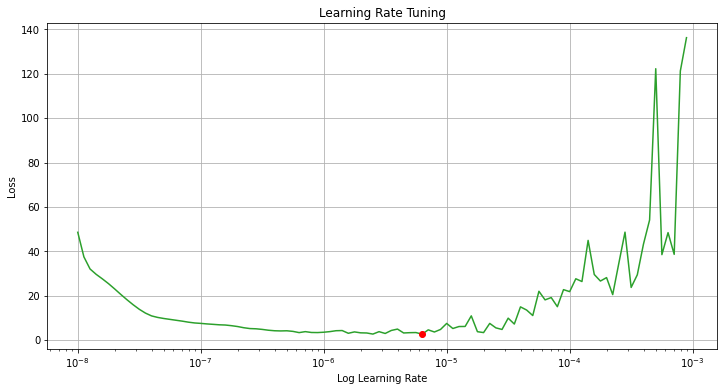

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(history_tune.history['lr'], history_tune.history['loss'], color="C2")
plt.plot(learning_rate, min_loss, 'ro')    
plt.xlabel('Log Learning Rate')
plt.ylabel('Loss')
plt.xscale('log')
plt.title('Learning Rate Tuning')
plt.grid(True)
plt.show()

## Training the model

In [16]:
def build_model():
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters = 60, kernel_size = 5,
                          strides = 1, padding = "causal",
                          activation = "relu",
                          input_shape = [None, 1]),
      tf.keras.layers.LSTM(60, return_sequences = True),
      tf.keras.layers.LSTM(60, return_sequences = True),
      tf.keras.layers.Dense(30, activation = "relu"),
      tf.keras.layers.Dense(10, activation = "relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400)
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)
    model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer, metrics = ["mae"])
    return model

model = build_model()

In [17]:
plot_model(model, to_file = 'lstm_model_plot.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [18]:
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
history_train = model.fit(train_set, epochs = epochs, validation_data = valid_set)

Epoch 1/500
45/45 [==============================] - 12s 226ms/step - loss: 11.6530 - mae: 12.1391 - val_loss: 6.0035 - val_mae: 6.4894
Epoch 2/500
45/45 [==============================] - 10s 224ms/step - loss: 12.0604 - mae: 12.5532 - val_loss: 17.6552 - val_mae: 18.1542
Epoch 3/500
45/45 [==============================] - 11s 234ms/step - loss: 12.5962 - mae: 13.0889 - val_loss: 8.8394 - val_mae: 9.3319
Epoch 4/500
45/45 [==============================] - 11s 235ms/step - loss: 4.7724 - mae: 5.2541 - val_loss: 3.5901 - val_mae: 4.0599
Epoch 5/500
45/45 [==============================] - 11s 238ms/step - loss: 5.7146 - mae: 6.2044 - val_loss: 8.4239 - val_mae: 8.9183
Epoch 6/500
45/45 [==============================] - 10s 231ms/step - loss: 8.0152 - mae: 8.5042 - val_loss: 4.6766 - val_mae: 5.1560
Epoch 7/500
45/45 [==============================] - 10s 227ms/step - loss: 4.7496 - mae: 5.2299 - val_loss: 3.0748 - val_mae: 3.5334
Epoch 8/500
45/45 [==============================] - 1

Epoch 62/500
45/45 [==============================] - 9s 204ms/step - loss: 1.1724 - mae: 1.6150 - val_loss: 1.4236 - val_mae: 1.8399
Epoch 63/500
45/45 [==============================] - 10s 213ms/step - loss: 0.9435 - mae: 1.3622 - val_loss: 1.3585 - val_mae: 1.7854
Epoch 64/500
45/45 [==============================] - 10s 210ms/step - loss: 1.5283 - mae: 1.9884 - val_loss: 2.8221 - val_mae: 3.3052
Epoch 65/500
45/45 [==============================] - 10s 210ms/step - loss: 2.8150 - mae: 3.2595 - val_loss: 3.2796 - val_mae: 3.7643
Epoch 66/500
45/45 [==============================] - 10s 214ms/step - loss: 2.5651 - mae: 3.0048 - val_loss: 1.7201 - val_mae: 2.1492
Epoch 67/500
45/45 [==============================] - 10s 224ms/step - loss: 1.3967 - mae: 1.8338 - val_loss: 1.7477 - val_mae: 2.1721
Epoch 68/500
45/45 [==============================] - 10s 215ms/step - loss: 1.1383 - mae: 1.5772 - val_loss: 1.6908 - val_mae: 2.1433
Epoch 69/500
45/45 [==============================] - 10

Epoch 123/500
45/45 [==============================] - 9s 208ms/step - loss: 0.7939 - mae: 1.1750 - val_loss: 1.5174 - val_mae: 1.9491
Epoch 124/500
45/45 [==============================] - 9s 207ms/step - loss: 0.7907 - mae: 1.1904 - val_loss: 1.2358 - val_mae: 1.6577
Epoch 125/500
45/45 [==============================] - 9s 207ms/step - loss: 0.9980 - mae: 1.4444 - val_loss: 1.1674 - val_mae: 1.5798
Epoch 126/500
45/45 [==============================] - 9s 208ms/step - loss: 0.6974 - mae: 1.0612 - val_loss: 1.1507 - val_mae: 1.5539
Epoch 127/500
45/45 [==============================] - 9s 207ms/step - loss: 0.9377 - mae: 1.3731 - val_loss: 1.1413 - val_mae: 1.5459
Epoch 128/500
45/45 [==============================] - 9s 206ms/step - loss: 0.6521 - mae: 1.0156 - val_loss: 1.2241 - val_mae: 1.6457
Epoch 129/500
45/45 [==============================] - 9s 209ms/step - loss: 0.7496 - mae: 1.1474 - val_loss: 1.2511 - val_mae: 1.6741
Epoch 130/500
45/45 [==============================] - 

45/45 [==============================] - 10s 211ms/step - loss: 1.0375 - mae: 1.4628 - val_loss: 1.3174 - val_mae: 1.7404
Epoch 184/500
45/45 [==============================] - 10s 213ms/step - loss: 0.9231 - mae: 1.3417 - val_loss: 1.4354 - val_mae: 1.8558
Epoch 185/500
45/45 [==============================] - 10s 212ms/step - loss: 1.0070 - mae: 1.4315 - val_loss: 1.2761 - val_mae: 1.6822
Epoch 186/500
45/45 [==============================] - 10s 212ms/step - loss: 1.9935 - mae: 2.4650 - val_loss: 3.4299 - val_mae: 3.9204
Epoch 187/500
45/45 [==============================] - 10s 219ms/step - loss: 2.1954 - mae: 2.6557 - val_loss: 1.9465 - val_mae: 2.4037
Epoch 188/500
45/45 [==============================] - 10s 217ms/step - loss: 1.9780 - mae: 2.4501 - val_loss: 1.4172 - val_mae: 1.8448
Epoch 189/500
45/45 [==============================] - 10s 214ms/step - loss: 0.8325 - mae: 1.2389 - val_loss: 1.2360 - val_mae: 1.6460
Epoch 190/500
45/45 [==============================] - 10s 216

45/45 [==============================] - 10s 223ms/step - loss: 0.6651 - mae: 1.0618 - val_loss: 1.0648 - val_mae: 1.4678
Epoch 244/500
45/45 [==============================] - 10s 224ms/step - loss: 0.7303 - mae: 1.1162 - val_loss: 1.3428 - val_mae: 1.7609
Epoch 245/500
45/45 [==============================] - 10s 222ms/step - loss: 0.8568 - mae: 1.2782 - val_loss: 1.3023 - val_mae: 1.7328
Epoch 246/500
45/45 [==============================] - 10s 226ms/step - loss: 1.2756 - mae: 1.7300 - val_loss: 1.3269 - val_mae: 1.7519
Epoch 247/500
45/45 [==============================] - 10s 226ms/step - loss: 0.9149 - mae: 1.3371 - val_loss: 1.1236 - val_mae: 1.5258
Epoch 248/500
45/45 [==============================] - 10s 218ms/step - loss: 0.8083 - mae: 1.2183 - val_loss: 1.0858 - val_mae: 1.4894
Epoch 249/500
45/45 [==============================] - 10s 219ms/step - loss: 0.5697 - mae: 0.9183 - val_loss: 1.1620 - val_mae: 1.5733
Epoch 250/500
45/45 [==============================] - 10s 221

45/45 [==============================] - 10s 224ms/step - loss: 0.5015 - mae: 0.8511 - val_loss: 1.5452 - val_mae: 2.0073
Epoch 304/500
45/45 [==============================] - 10s 224ms/step - loss: 0.7535 - mae: 1.1219 - val_loss: 1.7234 - val_mae: 2.1726
Epoch 305/500
45/45 [==============================] - 10s 225ms/step - loss: 1.1604 - mae: 1.6020 - val_loss: 1.0751 - val_mae: 1.4719
Epoch 306/500
45/45 [==============================] - 10s 225ms/step - loss: 0.8369 - mae: 1.2481 - val_loss: 1.1807 - val_mae: 1.6005
Epoch 307/500
45/45 [==============================] - 10s 224ms/step - loss: 0.7399 - mae: 1.1122 - val_loss: 1.2480 - val_mae: 1.6689
Epoch 308/500
45/45 [==============================] - 10s 226ms/step - loss: 0.6823 - mae: 1.0789 - val_loss: 1.0816 - val_mae: 1.4934
Epoch 309/500
45/45 [==============================] - 10s 228ms/step - loss: 0.6311 - mae: 1.0172 - val_loss: 1.2636 - val_mae: 1.6960
Epoch 310/500
45/45 [==============================] - 10s 228

45/45 [==============================] - 11s 233ms/step - loss: 0.5016 - mae: 0.8466 - val_loss: 0.9459 - val_mae: 1.3332
Epoch 364/500
45/45 [==============================] - 11s 234ms/step - loss: 0.5038 - mae: 0.8646 - val_loss: 0.9577 - val_mae: 1.3464
Epoch 365/500
45/45 [==============================] - 11s 240ms/step - loss: 0.5285 - mae: 0.8884 - val_loss: 1.1650 - val_mae: 1.5900
Epoch 366/500
45/45 [==============================] - 11s 238ms/step - loss: 0.5231 - mae: 0.8718 - val_loss: 0.9859 - val_mae: 1.3775
Epoch 367/500
45/45 [==============================] - 11s 238ms/step - loss: 0.6174 - mae: 1.0133 - val_loss: 0.9736 - val_mae: 1.3634
Epoch 368/500
45/45 [==============================] - 11s 235ms/step - loss: 0.5998 - mae: 0.9878 - val_loss: 1.2334 - val_mae: 1.6649
Epoch 369/500
45/45 [==============================] - 11s 240ms/step - loss: 0.5698 - mae: 0.9270 - val_loss: 1.0307 - val_mae: 1.4244
Epoch 370/500
45/45 [==============================] - 11s 244

45/45 [==============================] - 12s 254ms/step - loss: 0.6417 - mae: 1.0319 - val_loss: 0.9249 - val_mae: 1.3073
Epoch 424/500
45/45 [==============================] - 11s 253ms/step - loss: 0.6070 - mae: 0.9896 - val_loss: 1.0434 - val_mae: 1.4536
Epoch 425/500
45/45 [==============================] - 12s 256ms/step - loss: 0.5996 - mae: 0.9731 - val_loss: 1.0337 - val_mae: 1.4339
Epoch 426/500
45/45 [==============================] - 12s 254ms/step - loss: 1.3727 - mae: 1.8262 - val_loss: 1.7518 - val_mae: 2.2221
Epoch 427/500
45/45 [==============================] - 12s 257ms/step - loss: 0.6176 - mae: 1.0112 - val_loss: 0.9991 - val_mae: 1.3930
Epoch 428/500
45/45 [==============================] - 11s 253ms/step - loss: 1.0425 - mae: 1.4841 - val_loss: 1.0066 - val_mae: 1.3960
Epoch 429/500
45/45 [==============================] - 11s 253ms/step - loss: 0.4420 - mae: 0.7773 - val_loss: 0.9268 - val_mae: 1.3095
Epoch 430/500
45/45 [==============================] - 12s 255

45/45 [==============================] - 12s 260ms/step - loss: 0.4241 - mae: 0.7385 - val_loss: 0.9535 - val_mae: 1.3469
Epoch 484/500
45/45 [==============================] - 12s 258ms/step - loss: 0.4520 - mae: 0.8011 - val_loss: 0.9054 - val_mae: 1.2839
Epoch 485/500
45/45 [==============================] - 12s 257ms/step - loss: 0.4305 - mae: 0.7441 - val_loss: 0.9486 - val_mae: 1.3402
Epoch 486/500
45/45 [==============================] - 12s 258ms/step - loss: 0.4477 - mae: 0.7787 - val_loss: 0.9771 - val_mae: 1.3792
Epoch 487/500
45/45 [==============================] - 12s 259ms/step - loss: 0.6134 - mae: 1.0043 - val_loss: 0.8919 - val_mae: 1.2667
Epoch 488/500
45/45 [==============================] - 12s 257ms/step - loss: 0.6663 - mae: 1.0582 - val_loss: 0.9515 - val_mae: 1.3371
Epoch 489/500
45/45 [==============================] - 12s 257ms/step - loss: 0.4172 - mae: 0.7394 - val_loss: 0.9352 - val_mae: 1.3321
Epoch 490/500
45/45 [==============================] - 12s 263

## Forcasting

In [19]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

404/404 [==============================] - 7s 15ms/step


Text(0.5, 1.0, 'Forcasting')

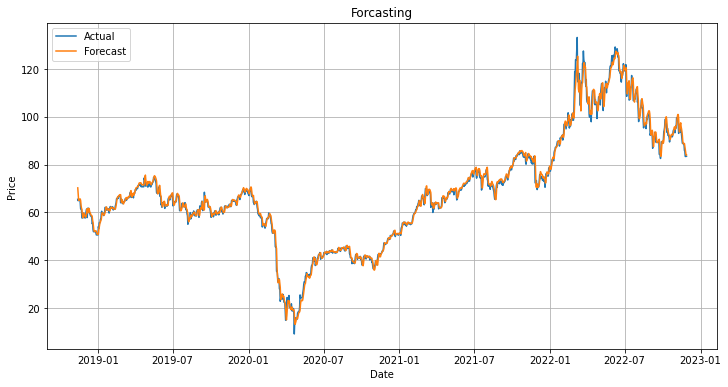

In [20]:
plt.figure(figsize=(12, 6))
plot_series(x_label_valid['Date'], x_valid)
plot_series(x_label_valid['Date'], rnn_forecast)
plt.legend(['Actual', 'Forecast'], loc = 'upper left')
plt.title('Forcasting')

Text(0.5, 1.0, 'Forcasting')

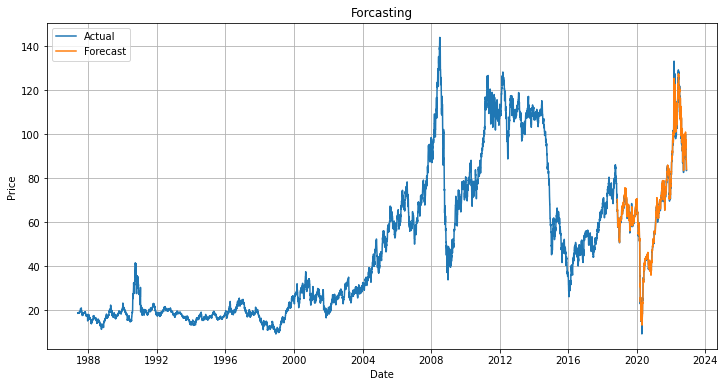

In [21]:
plt.figure(figsize=(12, 6))
plot_series(df['Date'], df['Price'])
plot_series(x_label_valid['Date'], rnn_forecast)
plt.legend(['Actual', 'Forecast'], loc = 'upper left')
plt.title('Forcasting')

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

array([17.623377, 17.654955, 17.617905, ..., 23.26978 , 23.26978 ,
       23.322155], dtype=float32)

In [23]:
zoom_begin = epochs - 50
zoon_end = epochs + 1
x_last = list(range(zoom_begin, zoon_end))

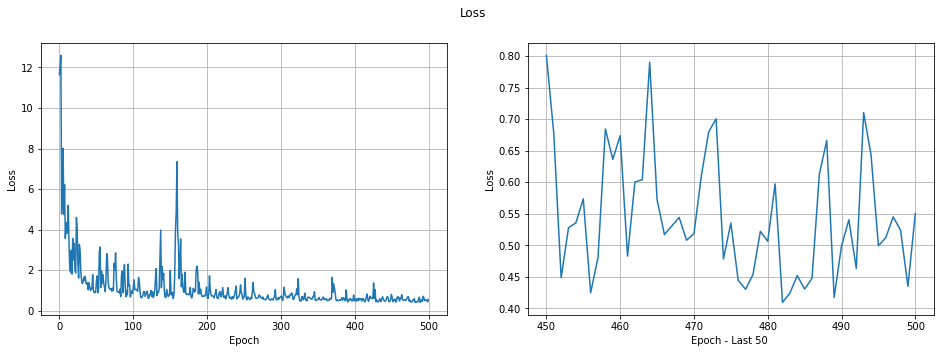

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Loss')
ax1.plot(range(0, epochs), history_train.history["loss"])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax2.plot(x_last, history_train.history["loss"][zoom_begin - 1:])
ax2.set_xlabel('Epoch - Last 50 ')
ax2.set_ylabel('Loss')
ax2.grid(True)

## Final training and saving

In [25]:
# The final model will be trained on the entire dataset
full_set = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)
final_model = build_model()
history_final = final_model.fit(full_set, epochs = epochs)
final_model.save('lstm_model')

Epoch 1/500
51/51 [==============================] - 13s 216ms/step - loss: 21.7028 - mae: 22.1981
Epoch 2/500
51/51 [==============================] - 12s 242ms/step - loss: 7.1071 - mae: 7.5884
Epoch 3/500
51/51 [==============================] - 13s 246ms/step - loss: 5.8263 - mae: 6.3079
Epoch 4/500
51/51 [==============================] - 13s 251ms/step - loss: 3.6428 - mae: 4.1099
Epoch 5/500
51/51 [==============================] - 13s 249ms/step - loss: 6.3970 - mae: 6.8836
Epoch 6/500
51/51 [==============================] - 13s 251ms/step - loss: 3.3382 - mae: 3.8017
Epoch 7/500
51/51 [==============================] - 13s 251ms/step - loss: 5.5887 - mae: 6.0760
Epoch 8/500
51/51 [==============================] - 13s 253ms/step - loss: 3.7863 - mae: 4.2599
Epoch 9/500
51/51 [==============================] - 13s 250ms/step - loss: 4.8305 - mae: 5.3125
Epoch 10/500
51/51 [==============================] - 13s 251ms/step - loss: 3.4669 - mae: 3.9515
Epoch 11/500
51/51 [=======

51/51 [==============================] - 14s 267ms/step - loss: 1.0451 - mae: 1.4797
Epoch 85/500
51/51 [==============================] - 14s 264ms/step - loss: 1.1121 - mae: 1.5481
Epoch 86/500
51/51 [==============================] - 14s 271ms/step - loss: 0.7955 - mae: 1.1906
Epoch 87/500
51/51 [==============================] - 14s 269ms/step - loss: 1.0213 - mae: 1.4495
Epoch 88/500
51/51 [==============================] - 14s 273ms/step - loss: 0.7166 - mae: 1.0631
Epoch 89/500
51/51 [==============================] - 14s 272ms/step - loss: 0.7250 - mae: 1.0832
Epoch 90/500
51/51 [==============================] - 14s 268ms/step - loss: 1.9376 - mae: 2.4009
Epoch 91/500
51/51 [==============================] - 14s 266ms/step - loss: 0.9899 - mae: 1.4134
Epoch 92/500
51/51 [==============================] - 14s 266ms/step - loss: 1.1079 - mae: 1.5473
Epoch 93/500
51/51 [==============================] - 14s 266ms/step - loss: 0.6820 - mae: 1.0308
Epoch 94/500
51/51 [=============

51/51 [==============================] - 14s 278ms/step - loss: 0.5909 - mae: 0.9531
Epoch 168/500
51/51 [==============================] - 14s 275ms/step - loss: 1.1291 - mae: 1.4680
Epoch 169/500
51/51 [==============================] - 14s 275ms/step - loss: 1.2573 - mae: 1.6934
Epoch 170/500
51/51 [==============================] - 14s 278ms/step - loss: 0.8191 - mae: 1.2156
Epoch 171/500
51/51 [==============================] - 14s 278ms/step - loss: 0.6092 - mae: 0.9580
Epoch 172/500
51/51 [==============================] - 14s 279ms/step - loss: 0.6775 - mae: 1.0469
Epoch 173/500
51/51 [==============================] - 14s 281ms/step - loss: 0.6503 - mae: 1.0260
Epoch 174/500
51/51 [==============================] - 14s 279ms/step - loss: 0.5521 - mae: 0.8738
Epoch 175/500
51/51 [==============================] - 14s 278ms/step - loss: 0.6163 - mae: 0.9512
Epoch 176/500
51/51 [==============================] - 14s 275ms/step - loss: 0.5709 - mae: 0.9233
Epoch 177/500
51/51 [===

51/51 [==============================] - 13s 251ms/step - loss: 0.8433 - mae: 1.2675
Epoch 250/500
51/51 [==============================] - 16s 321ms/step - loss: 0.6120 - mae: 0.9587
Epoch 251/500
51/51 [==============================] - 15s 293ms/step - loss: 0.6603 - mae: 1.0380
Epoch 252/500
51/51 [==============================] - 15s 296ms/step - loss: 1.6440 - mae: 2.0986
Epoch 253/500
51/51 [==============================] - 15s 296ms/step - loss: 0.9376 - mae: 1.3645
Epoch 254/500
51/51 [==============================] - 15s 295ms/step - loss: 0.6631 - mae: 1.0517
Epoch 255/500
51/51 [==============================] - 15s 298ms/step - loss: 0.5395 - mae: 0.8826
Epoch 256/500
51/51 [==============================] - 15s 300ms/step - loss: 0.6315 - mae: 1.0098
Epoch 257/500
51/51 [==============================] - 15s 299ms/step - loss: 0.5604 - mae: 0.9158
Epoch 258/500
51/51 [==============================] - 15s 296ms/step - loss: 0.5992 - mae: 0.9813
Epoch 259/500
51/51 [===

51/51 [==============================] - 16s 309ms/step - loss: 0.5531 - mae: 0.9124
Epoch 332/500
51/51 [==============================] - 16s 308ms/step - loss: 0.7302 - mae: 1.1436
Epoch 333/500
51/51 [==============================] - 16s 307ms/step - loss: 0.5431 - mae: 0.9084
Epoch 334/500
51/51 [==============================] - 16s 303ms/step - loss: 0.4877 - mae: 0.8056
Epoch 335/500
51/51 [==============================] - 16s 310ms/step - loss: 0.4396 - mae: 0.7669
Epoch 336/500
51/51 [==============================] - 16s 310ms/step - loss: 0.5018 - mae: 0.8418
Epoch 337/500
51/51 [==============================] - 16s 310ms/step - loss: 0.5490 - mae: 0.9050
Epoch 338/500
51/51 [==============================] - 16s 313ms/step - loss: 0.8242 - mae: 1.2105
Epoch 339/500
51/51 [==============================] - 16s 313ms/step - loss: 0.5096 - mae: 0.8607
Epoch 340/500
51/51 [==============================] - 16s 310ms/step - loss: 0.5174 - mae: 0.8586
Epoch 341/500
51/51 [===

51/51 [==============================] - 14s 278ms/step - loss: 0.6305 - mae: 1.0240
Epoch 414/500
51/51 [==============================] - 14s 273ms/step - loss: 0.4662 - mae: 0.7799
Epoch 415/500
51/51 [==============================] - 16s 313ms/step - loss: 0.4441 - mae: 0.7485
Epoch 416/500
51/51 [==============================] - 16s 315ms/step - loss: 0.4533 - mae: 0.7713
Epoch 417/500
51/51 [==============================] - 14s 277ms/step - loss: 0.4356 - mae: 0.7452
Epoch 418/500
51/51 [==============================] - 14s 275ms/step - loss: 0.4566 - mae: 0.7676
Epoch 419/500
51/51 [==============================] - 14s 274ms/step - loss: 0.4494 - mae: 0.7578
Epoch 420/500
51/51 [==============================] - 14s 275ms/step - loss: 0.5064 - mae: 0.8407
Epoch 421/500
51/51 [==============================] - 14s 273ms/step - loss: 0.5154 - mae: 0.8683
Epoch 422/500
51/51 [==============================] - 14s 276ms/step - loss: 0.5616 - mae: 0.9218
Epoch 423/500
51/51 [===

51/51 [==============================] - 15s 284ms/step - loss: 0.4724 - mae: 0.7830
Epoch 496/500
51/51 [==============================] - 15s 285ms/step - loss: 0.5501 - mae: 0.8978
Epoch 497/500
51/51 [==============================] - 15s 284ms/step - loss: 0.4514 - mae: 0.7872
Epoch 498/500
51/51 [==============================] - 15s 283ms/step - loss: 0.5382 - mae: 0.8803
Epoch 499/500
51/51 [==============================] - 14s 275ms/step - loss: 0.5112 - mae: 0.8562
Epoch 500/500
51/51 [==============================] - 17s 324ms/step - loss: 0.4692 - mae: 0.8043


INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets
